<!-- # **Học thống kê - 20TN** -->
# **Lab assignment 2:** Logistic Regression

**Student's information:**
- **Name:** Nguyễn Bảo Tín 
- **Student ID:** 20120596

#### **Table of contents**

<ul style="list-style-type: none">
    <li><a href="#import">0 - Import libraries</a></li>
    <li><a href="#step1">1 - Load and Visualize data</a></li>
    <li><a href="#step1.1">&emsp; 1.1 - Load data</a></li>
    <li><a href="#step1.2">&emsp; 1.2 - Visualize</a></li>
    <li><a href="#step1.3">&emsp; 1.3 - Map x1, x2 to a new data domain with 28 dimensions</a></li>
    <li><a href="#step2">2 - Implement model and some helper functions</a></li>
    <li><a href="#step3">3 - Train model</a></li>
    <li><a href="#plot">&emsp; Plot the Loss throughout the Learning process</a></li>
    <li><a href="#step4">4 - Evaluate model</a></li>
    <li><a href="#step5">5 - Draw decision boundary</a></li>
    <li><a href="#step6">6 - Save model and evaluation</a></li>
    <li><a href="#ref">References</a></li>
</ul>


<a id="baitoan"></a>

### **Yêu cầu**
<details>
  <summary>Click để xem yêu cầu</summary>
  
  - Cài đặt hồi quy logistic để dự đoán microchip của một nhà máy có đủ điều kiện để được bán ra thị trường hay không.
  - Dữ liệu thô bao gồm 3 cột: cột 1 và 2 là các đặc trưng, cột 3 là nhãn. 
  - Dữ liệu huấn luyện là dữ liệu thô sau khi ánh xạ sang miền dữ liệu mới gồm 28 chiều. 
  - Cài đặt các hàm phụ trợ sau để thực hiện việc huấn luyện và dự đoán: 
    - compute_cost: tính toán chi phí của mô hình trên tập dữ liệu (công thức hàm chi phí được cung cấp trong phần 3). 
    - compute_gradient:  tính  vector  gradient  của  hàm  chi  phí  (công  thức  tính  vector gradient được cung cấp trong phần 3). 
    - gradient_descent: tính gradient descent. 
    - predict: dự đoán một tập các microchip có đủ điều kiện để bán ra thị trường hay không (nếu muốn dự đoán cho 1 microchip thì phải truyền vào một mảng gồm 1 phần tử). 
    - evaluate: đánh giá kết quả dự đoán của mô hình dựa trên các độ đo: accuracy, precision, recall và F1-score (tương tự phương thức classification_report của scikit-learn).
  - Tiếp theo đó, sinh viên cần sử dụng các hàm phụ trợ để cài đặt phần chương trình chính bao gồm các yêu cầu sau: 
    - Đọc cấu hình huấn luyện từ tập tin config.json. 
    - Huấn luyện với dữ liệu được cung cấp từ tập tin training_data.txt. 
    - Lưu mô hình huấn luyện được vào tập tin model.json. 
    - Dự đoán và đánh giá kết quả huấn luyện trên tập dữ liệu huấn luyện, lưu kết quả đánh giá vào tập tin classification_report.json. 
</details>

<a id="import"></a>

### **0 - Import Libraries**

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from map_feature import map_feature, map_feature_one_point
import json

# make sure plot will be displayed below the code,
# not in a separate window.
%matplotlib inline

THRESHOLD = 0.5

<a id="step1"></a>

### **1 - Load and Visualize data**

<a id="step1.1"></a>

#### **1.1 - Load data**: Load data from training_data.txt file.

In [2]:
# load dataset
df = pd.read_csv('training_data.txt', sep=',', header=None)
df.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [3]:
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

<a id="step1.2"></a>

#### **1.2 - Visualize**

In [4]:
def plot_data(X, y, title = "Plot_data", pos_label="y = 1", neg_label="y = 0"):
    pos = np.where(y == 1)
    neg = np.where(y == 0)
    plt.scatter(X[pos, 0], X[pos, 1], color='green', s=20, label=pos_label)
    plt.scatter(X[neg, 0], X[neg, 1], color='red', s=20, label=neg_label)
    plt.legend()
    plt.title(title)

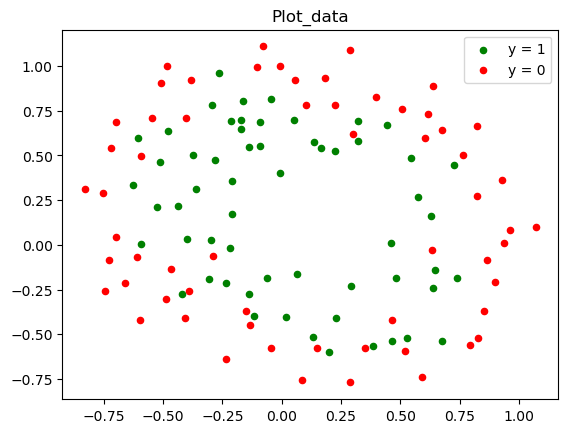

In [5]:
plot_data(X, y)

<a id="step1.3"></a>

#### **1.3 - Map x1, x2 to a new data domain with 28 dimensions.**

In [6]:
# map x1, x2 to 28-D features.
X_mapped = map_feature(X[:,0], X[:,1])

<a id="step2"></a>

### **2 - Implement model and some helper functions**

In [7]:
# sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [8]:
# padding the column of 1 to the beginning of X
def padding_X(X):
    X = np.concatenate((np.ones((X.shape[0], 1)), X), axis = 1)
    return X

In [9]:
class LogisticRegression:
    def __init__(self, alpha=0.5, iters=10000, lambda_= 1, verbose=False):
        self.alpha = alpha
        self.iters = iters
        self.lambda_ = lambda_
        self.verbose = verbose
        self.theta = None
    
    def compute_cost(self, X, y):
        rows = X.shape[0]
        
        cost = 0
        for i in range(rows):
            hypo = sigmoid(np.dot(X[i], self.theta))
            cost += -y[i] * np.log(hypo) - (1 - y[i]) * np.log(1 - hypo)
        
        # add regularization cost
        return cost / rows + (self.lambda_ / (2 * rows)) * np.sum(np.square(self.theta))
    
    def compute_gradient(self, X, y):
        rows, cols = X.shape
        dtheta = np.zeros(cols)

        for i in range(rows):
            hypo = sigmoid(np.dot(X[i], self.theta))          
            error  = hypo  - y[i]
            dtheta += error * X[i]
        
        dtheta = dtheta / rows
        dtheta += (self.lambda_ / rows) * self.theta
        return dtheta
    
    def gradient_descent(self, X, y):
        cols = X.shape[1]
        # randomly choose w in range [-1, 1]
        self.theta = np.random.rand(cols) * 2 - 1

        J_history = [] # save history of J (loss function) to visualize how well the model learned to decrease the loss.
        
        for i in range(self.iters):
            # Calculate gradient
            dtheta = self.compute_gradient(X, y)   

            # Update Parameters
            self.theta -= self.alpha * dtheta
            cost =  self.compute_cost(X, y)
            J_history.append(cost)

            # Print loss
            if self.verbose:
                if i in [self.iters * k / 10 - 1 for k in range(1, 10)] or i == self.iters - 1 or i == 0:
                    print(f"Iteration {i + 1:4}: Loss {float(J_history[-1]):4.3f}.")
            
        return self.theta, J_history
    
    def fit(self, X, y):
        # padding a column of 1 to the beginning of X.
        X = padding_X(X)
        return self.gradient_descent(X, y)
    
    def predict(self, X, threshold=0.5):
        rows = X.shape[0]
        y_pred = np.zeros(rows)

        for i in range(rows):   
            # calculate the probability for each row's result to be 1.
            prob = sigmoid(np.dot(X[i], self.theta))

            # Determine the result of prediction depending on the threshold = 0.5
            y_pred[i] = 1 if prob >= threshold else 0
        
        return y_pred

    def evaluate(self, X, y):
        # padding a column of 1 to the beginning of X.
        X = padding_X(X)
        y_pred = self.predict(X)
        n_eval = X.shape[0]

        # accuracy = number of predictions that exactly matched with the labels.
        accuracy = sum([1 for i in range(n_eval) if y_pred[i] == y[i]]) * 1.0 / n_eval

        # print summary of evaluation
        print("-------EVALUATION OF LOGISTIC REGRESSION MODEL-------")
        print(f"Accuracy: {accuracy:.5f}\n")
        
        report = []
        for label in set(y):
            # calculate true positives, false positives, and false negatives
            tp = sum([1 for i in range(n_eval) if y[i] == label and y_pred[i] == label])
            fp = sum([1 for i in range(n_eval) if y[i] != label and y_pred[i] == label])
            fn = sum([1 for i in range(n_eval) if y[i] == label and y_pred[i] != label])

            precision = tp * 1.0 / (tp + fp)
            recall = tp * 1.0 / (tp + fn)
            f1_score = 2 * (precision * recall) / (precision + recall)
            support = sum(y == label)
            
            report.append([precision, recall, f1_score, support])

        # create a list of row labels
        row_labels = ['class 0', 'class 1']

        df = pd.DataFrame(report, index = row_labels, columns = ['precision', 'recall', 'f1-score', 'support'])
        print("Classification report:")
        print(df)

        return accuracy, report

<a id="step3"></a>

### **3 - Train model**

In [10]:
# Load config
with open('config.json',) as f:
    configs = json.load(f)

model = LogisticRegression(alpha=configs['Alpha'], iters=configs['NumIter'], lambda_=configs['Lambda'],verbose=True)
history = model.fit(X_mapped, y)

Iteration    1: Loss 0.808.
Iteration  100: Loss 0.602.
Iteration  200: Loss 0.561.
Iteration  300: Loss 0.546.
Iteration  400: Loss 0.539.
Iteration  500: Loss 0.536.
Iteration  600: Loss 0.534.
Iteration  700: Loss 0.533.
Iteration  800: Loss 0.533.
Iteration  900: Loss 0.533.
Iteration 1000: Loss 0.532.


<a id="plot"></a>

#### **Plot the Loss throughout the Learning process**

In [11]:
def plot_model(model, history):
    x_axis = [i for i in range(model.iters)]
    plt.plot(x_axis, history[1])
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title(f"Learning process with learning rate alpha = {model.alpha}")
    plt.show()

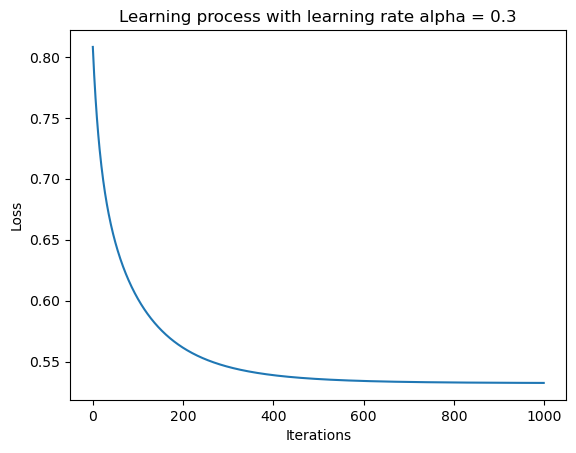

In [12]:
plot_model(model, history)

<a id="step4"></a>

### **4 - Evaluate model**
Evaluate model on the whole training data by using *model.evaluate* method, which returns the **accuracy**, **precision**, **recall** and **F1 score**.

In [13]:
evaluation = model.evaluate(X_mapped, y)

-------EVALUATION OF LOGISTIC REGRESSION MODEL-------
Accuracy: 0.83051

Classification report:
         precision    recall  f1-score  support
class 0   0.900000  0.750000  0.818182       60
class 1   0.779412  0.913793  0.841270       58


<a id="step5"></a>

### **5 - Draw decision boundary**
Draw decision boundary with [contour](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html) function from [matplotlib](https://matplotlib.org/) library.

This function will draw a boundary separating data labeled with 0 and 1.

In [14]:
def plot_decision_boundary(theta, X, y):
    plot_data(X, y, "Draw decision boundary")
    
    x_coor = np.linspace(np.min(X[:,0]) - 0.05, np.max(X[:,0]) + 0.05, 50)
    y_coor = np.linspace(np.min(X[:,1]) - 0.05, np.max(X[:,1]) + 0.05, 50)
    z_coor = np.zeros((x_coor.shape[0], y_coor.shape[0]))

    # calculate z coordinates for every (x_coor, y_coor) point 
    # by using the sigmoid function after mapping -> 28-D
    for i in range(len(x_coor)):
        for j in range(len(y_coor)):
            z_coor[i,j] = sigmoid(np.dot(np.insert(map_feature_one_point(x_coor[i], y_coor[j]), 0, 1), theta))

    plt.contour(x_coor, y_coor, z_coor.T, levels = [THRESHOLD], colors=["blue"])

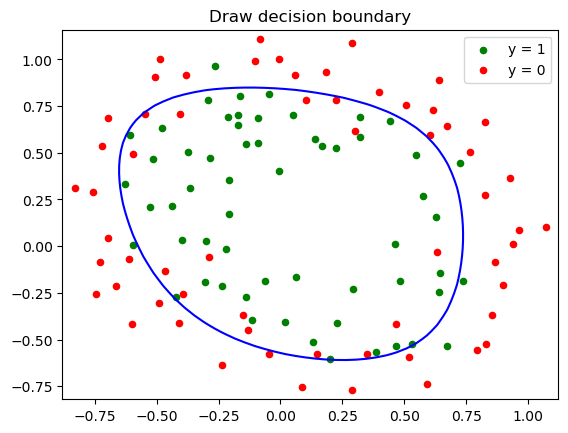

In [15]:
plot_decision_boundary(model.theta, X, y)

<a id="step6"></a>

### **6 - Save model and evaluation**
- **Save model**: save parameters theta to *model.json* file.
- **Save evaluation**: save result of evaluation to *classification_report.json* file. 

In [16]:
# Save model
with open('model.json', 'w') as f:
    json.dump({'theta': model.theta.tolist()}, f)

In [17]:
# prepare report
report = []
result = {'Accuracy': evaluation[0],
           'Class 0': [],
           'Class 1': []}

class_0 = {'Precision': evaluation[1][0][0],
            'Recall': evaluation[1][0][1],
            'F1_score': evaluation[1][0][2],
            'Support': int(evaluation[1][0][3])} # convert np.int32 to int (avoid ParseError)
class_1 = {'Precision': evaluation[1][1][0],
            'Recall': evaluation[1][1][1],
            'F1_score': evaluation[1][1][2],
            'Support': int(evaluation[1][1][3])} # convert np.int32 to int (avoid ParserError)

result["Class 0"].append(class_0)
result["Class 1"].append(class_1)
report.append(result)

# Save evaluation result
with open('classification_report.json', 'w') as f:
    json.dump(report, f)

<a id="ref"></a>

### **References**
- [Supervised Machine Learning: Logistic Regression (Week 3) - Andrew Ng](https://www.coursera.org/learn/machine-learning#:~:text=Week%203%3A%20Classification)
- [Matplotlib API Reference](https://matplotlib.org/stable/api)
- [classification_report - Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)